# Attempt 1:
## Target: 
Reduce the parameters to less than 10K and try achieving 90+ accuracy

## Results:
Parameters: 8998 
Train Accuracy: 97.55%
Test Accuracy: 99.17% (max 99.21%)

## Analysis
Given the problem of classifying gray scale images into a total of 10 classes requires much lesser number of layers, hence tried to reduce the layers. Also updated batch size from previously 128 to now 64 value, as we saw from the batch size - accuracy graph, max accuracy was achieved with around 64 batch size. Also added rotation tranformation for data, which as we saw in class based on the dataset has helped in past.



# Import Libraries

In [1]:
# importing all the Python Packages & torch Library.
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Define Data Transformations

In [2]:
train_transforms = transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

# Dataloader Arguments & Train / Test Dataloaders

In [3]:
# seed the model to obtain consistent results
torch.manual_seed(1)
# this is the batch size , in 1 pas no of images passed together.
batch_size = 64
use_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

# load the training data and perform standard normalization 
# parameter for normalization is mean and std dev.
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms), batch_size=batch_size, shuffle=True, **kwargs)
#load the test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=test_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# The Model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias = True), # output 26X26X16 : RF- 3X3
            nn.ReLU(),
            nn.BatchNorm2d(16), # Batch Normalization after each convolution.
            nn.Dropout2d(0.1), # dropout of 10% at each layer
            
            nn.Conv2d(16, 32, 3), # output 24X24X32 : RF- 5x5
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch Normalization after each convolution.
            nn.Dropout2d(0.1),  # dropout of 10% at each layer

            nn.MaxPool2d(2, 2)       # output 12X12X32 : RF - 6x6 
            )
        self.conv2 = nn.Sequential(
            
           
           # using 1X1 filter to reduce the no of channel.
            nn.Conv2d(32, 8, 1), # output 12X12X8 : RF - 6x6
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.1),

            nn.Conv2d(8, 16, 3), # output 10X10X16 : RF - 10x10
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.MaxPool2d(2, 2) # output 5x5x16 RF - 12x12
            )
        self.conv3 = nn.Sequential(
           
            nn.Conv2d(16, 16, 3,padding=1), # output 5X5X16 : RF - 16x16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 10, 1), # output 5X5X10 : RF - 16x6
            nn.AvgPool2d(5) # output 1x1x10 : RF - 24x24

            )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x= self.conv2(x)
        x= self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, -1)

# Print Summary of Model

In [5]:
!pip install torchsummary
from torchsummary import summary
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,640
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
         Dropout2d-8           [-1, 32, 24, 24]               0
         MaxPool2d-9           [-1, 32, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             264
             ReLU-11            [-1, 8, 12, 12]               0
      BatchNorm2d-12            [-1, 8, 12, 12]              16
        Dropout2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

# Define Train and Test functions

In [6]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Function to train 
'''
Args: 
Model : created model to be used for training
device : GPU or cpu
train_laoded: data on which the training has to be done
Optimizer : the optimization algorithm to be used
epoch : no fo epoch 

'''
def train(model, device, train_loader, optimizer, epoch):
    model.train() # Set the model on training mode
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device) # moving the data to device
        optimizer.zero_grad() # zero the graidents 
        output = model(data) # getting the model output
        loss = F.nll_loss(output, target) # calculating the The negative log likelihood loss
        train_losses.append(loss)
        loss.backward() # flowing the gradients backward.
        optimizer.step() # paameter updated basd on the current gradient.
        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)        
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

# Function to test 
'''
Args: 
Model : created model to be used for training
device : GPU or cpu
test_laoded: data on which the testing has to be done
 

'''
def test(model, device, test_loader):
    model.eval() # seting up the model for evalaution.
    test_loss = 0 # setting the test loss to 0
    correct = 0 # countign the no of coorect classfication.
    with torch.no_grad(): # turn off gradients, since we are in test mode
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)   # copy the data to device.
            output = model(data) # predict the output
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) # calculating hte test loss.
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

# Run the model

In [7]:
 
model = Net().to(device) # move the model to device.
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # intiating the SGD optimizer

for epoch in range(1, 16):
    print("epoch =", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    

  0%|          | 0/938 [00:00<?, ?it/s]

epoch = 1


loss=0.36265894770622253 batch_id=937 Train Accuracy=79.07: 100%|██████████| 938/938 [00:17<00:00, 52.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1036, Test Accuracy: 9734/10000 (97.34%)

epoch = 2


loss=0.32558777928352356 batch_id=937 Train Accuracy=94.11: 100%|██████████| 938/938 [00:17<00:00, 52.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0654, Test Accuracy: 9821/10000 (98.21%)

epoch = 3


loss=0.08364958316087723 batch_id=937 Train Accuracy=95.56: 100%|██████████| 938/938 [00:17<00:00, 53.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Test Accuracy: 9841/10000 (98.41%)

epoch = 4


loss=0.17776425182819366 batch_id=937 Train Accuracy=96.11: 100%|██████████| 938/938 [00:17<00:00, 52.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Test Accuracy: 9855/10000 (98.55%)

epoch = 5


loss=0.029760167002677917 batch_id=937 Train Accuracy=96.54: 100%|██████████| 938/938 [00:17<00:00, 55.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Test Accuracy: 9877/10000 (98.77%)

epoch = 6


loss=0.23533093929290771 batch_id=937 Train Accuracy=96.74: 100%|██████████| 938/938 [00:17<00:00, 54.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Test Accuracy: 9886/10000 (98.86%)

epoch = 7


loss=0.09675814211368561 batch_id=937 Train Accuracy=96.85: 100%|██████████| 938/938 [00:16<00:00, 55.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Test Accuracy: 9891/10000 (98.91%)

epoch = 8


loss=0.08787176758050919 batch_id=937 Train Accuracy=97.08: 100%|██████████| 938/938 [00:16<00:00, 55.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Test Accuracy: 9913/10000 (99.13%)

epoch = 9


loss=0.029218824580311775 batch_id=937 Train Accuracy=97.15: 100%|██████████| 938/938 [00:16<00:00, 56.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Test Accuracy: 9899/10000 (98.99%)

epoch = 10


loss=0.1435006856918335 batch_id=937 Train Accuracy=97.24: 100%|██████████| 938/938 [00:18<00:00, 52.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Test Accuracy: 9917/10000 (99.17%)

epoch = 11


loss=0.33868834376335144 batch_id=937 Train Accuracy=97.40: 100%|██████████| 938/938 [00:17<00:00, 53.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Test Accuracy: 9909/10000 (99.09%)

epoch = 12


loss=0.24445326626300812 batch_id=937 Train Accuracy=97.38: 100%|██████████| 938/938 [00:19<00:00, 46.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Test Accuracy: 9921/10000 (99.21%)

epoch = 13


loss=0.1118166521191597 batch_id=937 Train Accuracy=97.51: 100%|██████████| 938/938 [00:18<00:00, 52.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Test Accuracy: 9914/10000 (99.14%)

epoch = 14


loss=0.07353457063436508 batch_id=937 Train Accuracy=97.51: 100%|██████████| 938/938 [00:18<00:00, 50.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Test Accuracy: 9912/10000 (99.12%)

epoch = 15


loss=0.017719803377985954 batch_id=937 Train Accuracy=97.55: 100%|██████████| 938/938 [00:17<00:00, 53.28it/s]



Test set: Average loss: 0.0285, Test Accuracy: 9917/10000 (99.17%)



# Plot results

Text(0.5, 1.0, 'Test Accuracy')

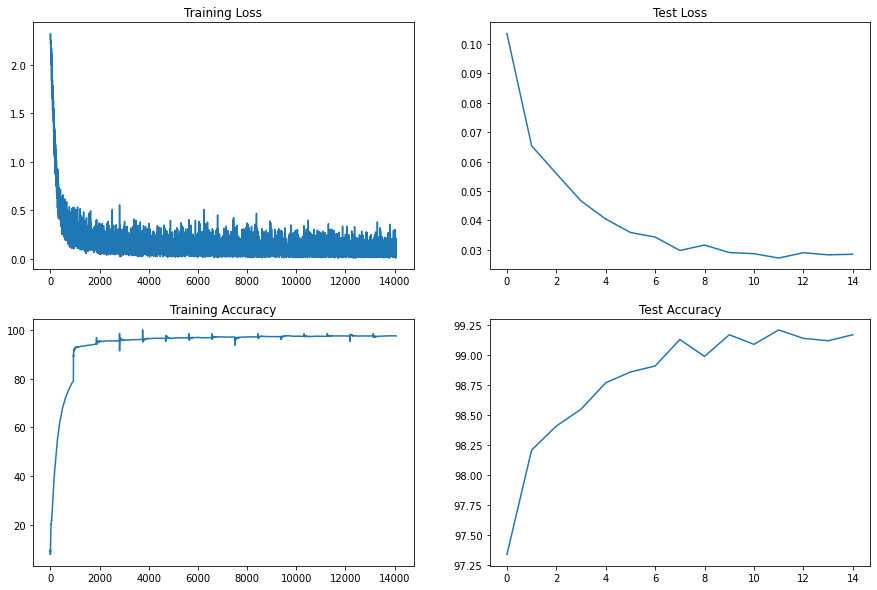

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")